# Hypothesis Testing

In [21]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.style.use('ggplot')

df = pd.read_csv('cosmetic.csv')

**Data Cleaning**

Recreating Sephora dataframe to grab arrays needed for hypothesis testing

In [6]:
#classify brand names as Korean/Western
korean_brands = ['LANEIGE', 'AMOREPACIFIC', 'DR. JART+', 'GLOW RECIPE', 'TOO COOL FOR SCHOOL', 'SON & PARK', 'J. ONE']
japanese_brands = ['TATCHA', 'SK-II', 'KOH GEN DO']
df['Classification'] = ['KOREAN' if val in korean_brands else 'JAPANESE' if val in japanese_brands else 'WESTERN' for val in df['brand']]

In [8]:
#search for the number of products that contain chemicals in chemical list
df['ingredients_final'] = df['ingredients']
chemical_list = ['Titanium Dioxide',
                 'Benzophenone',
                 'Ginkgo Biloba Extract',
                 'Coffee',
                 'Aloe Vera, Whole Leaf Extract',
                 'Caffeic Acid',
                 'Butylated Hydroxyanisole',
                 'Acetaldehyde',
                 'Benzo[A]Pyrene',
                 'Benz[A]Anthracene',
                 'Estragole',
                 'Safrole']

#create new chemical column that classifies brands that contain hazardous chemicals
df['Chem?'] = df['ingredients'].str.contains('|'.join(chemical_list))

#check if there are any null values
df['ingredients'].isnull().values.any()
#drop NA values
df2 = df.dropna()
df2.reset_index().head()

,index,Label,URL,brand,name,price,rank,skin_type,ingredients,Classification,ingredients_final,Chem?
0,0,moisturizing-cream-oils-mists,https://www.sephora.com/product/creme-de-la-me...,LA MER,Crème de la Mer,$175.00,4.1,"['✔ Normal\n', '✔ Oily\n', '✔ Combination\n', ...","Algae (Seaweed) Extract, Mineral Oil, Petrolat...",WESTERN,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",False
1,1,moisturizing-cream-oils-mists,https://www.sephora.com/product/facial-treatme...,SK-II,Facial Treatment Essence,$179.00\n($214.00 value),4.1,"['✔ Normal\n', '✔ Oily\n', '✔ Combination\n', ...","-Pitera™: A bio-ingredient rich in vitamins, o...",JAPANESE,"-Pitera™: A bio-ingredient rich in vitamins, o...",False
2,2,moisturizing-cream-oils-mists,https://www.sephora.com/product/protini-tm-pol...,DRUNK ELEPHANT,Protini™ Polypeptide Cream,$68.00,4.4,"['✔ Normal\n', '✔ Oily\n', '✔ Combination\n', ...",-9 Signal Peptide Complex \n-Pygmy Waterlily S...,WESTERN,-9 Signal Peptide Complex \n-Pygmy Waterlily S...,False
3,3,moisturizing-cream-oils-mists,https://www.sephora.com/product/the-moisturizi...,LA MER,The Moisturizing Soft Cream,$175.00,3.8,"['✔ Normal\n', '✔ Oily\n', '✔ Combination\n', ...","Algae (Seaweed) Extract, Cyclopentasiloxane, P...",WESTERN,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",False
4,4,moisturizing-cream-oils-mists,https://www.sephora.com/product/your-skin-but-...,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,$38.00,4.1,"['✔ Full\n', '✔ Sensitive\n', '✔ Normal\n', '✔...",-Collagen: Supports skin elasticity for a yout...,WESTERN,-Collagen: Supports skin elasticity for a yout...,False


In [9]:
sephora_df_hyp = df2[['name','Chem?', 'Classification']]
sephora_df_hyp2 = sephora_df_hyp[sephora_df_hyp['Classification'] != 'JAPANESE']
sephora_df_hyp2['Chem?'] = sephora_df_hyp2['Chem?'].astype(int)

sephora_df_hyp2['Chem?'].value_counts()
# sephora_df_hyp2.head()

/Users/seanleong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0    1174
1     406
Name: Chem?, dtype: int64

In [12]:
#create numpy array from Western Chemical series 
sephora_df_hyp_west = sephora_df_hyp2[sephora_df_hyp2['Classification'] == 'WESTERN']
sample_west = np.array(sephora_df_hyp_west['Chem?'].values.tolist())
sample_west
sum(sample_west)

380

In [13]:
#create numpy array from Korean Chemical series 
sephora_df_hyp_west = sephora_df_hyp2[sephora_df_hyp2['Classification'] == 'KOREAN']
sample_kor = np.array(sephora_df_hyp_west['Chem?'].values.tolist())
sample_kor
sum(sample_kor)

26

Based on the potentially hazardous chemicals found in the California Safe Cosmetics Program (CSCP) dataset, there are 12 types of ingredients that are harmful. These 12 types of ingredients were then identified in the list of ingredients found on the Sephora skincare dataset (categorized between Western and Korean) and tagged as being harmful or not. Below is a summary of the number of products that do and do not contain harmful ingredients by category.

![Summary Table](/images/Harmful_summary.png)

**Is the prevalance of toxic ingredients higher in Western skincare products than Korean ones?**

$$ p_K = P(\text{Korean skincare toxicity}) $$
$$ p_W = P(\text{Western skincare toxicity}) $$

$$ H_0: \ p_K = p_W $$

We assume that the number of toxic products for Korean and Western brands are independent of one another and are Binomially distributed. A normal approximaton is appropriate for these Binomial distributions.

$$ \text{# of toxic products in Korean products} \sim Binomial(93, p_K) $$
$$ \text{# of toxic products in Western prodcuts} \sim Binomial(1342, p_W) $$

In [14]:
#use student t-test
def welch_satterthwaite_df(sample1, sample2):
    ss1 = len(sample1)
    ss2 = len(sample2)
    df = (
        ((np.var(sample1)/ss1 + np.var(sample2)/ss2)**(2.0)) / 
        ((np.var(sample1)/ss1)**(2.0)/(ss1 - 1) + (np.var(sample2)/ss2)**(2.0)/(ss2 - 1))
    )
    return df

In [23]:
df= welch_satterthwaite_df(sample_west, sample_kor)
print(df)

118.28802105140457


Text(0.5,1,"Distribution of Welsh's Test Statistic Under the Null Hypothesis")

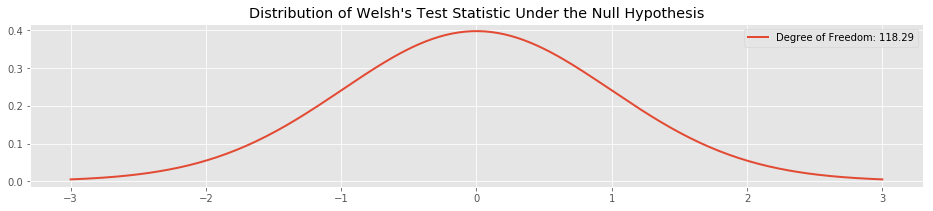

In [24]:
x = np.linspace(-3, 3, num=250)

fig, ax = plt.subplots(1, figsize=(16, 3))
students = stats.t(df)
ax.plot(x, students.pdf(x), linewidth=2, label="Degree of Freedom: {:2.2f}".format(df))
ax.legend()
ax.set_title("Distribution of Welsh's Test Statistic Under the Null Hypothesis")